In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.simplefilter('ignore')

In [7]:
plt.style.use('ggplot')

In [4]:
#2. Calculate the correlation between the price of $OCEAN and the number of messages, new users, and active individuals on the server. 
#   Provide insights from these correlations and suggest statistical methods for analysis.

In [141]:
ocean_discord = pd.read_csv('data/oceandiscord.csv')
ocean_discord['Date'] = pd.to_datetime(ocean_discord['Date'].astype(str).str[:10]) #just days
ocean_discord['message_count'] = 1

ocean_price = pd.read_csv('data/OCEAN-USD_price_data.csv')
ocean_price['Date'] = pd.to_datetime(ocean_price['Date'].astype(str).str[:10])


In [142]:
ocean_discord.Date.min(), ocean_discord.Date.max()

(Timestamp('2019-08-20 00:00:00'), Timestamp('2024-02-20 00:00:00'))

In [143]:
ocean_price.Date.min(), ocean_price.Date.max()

(Timestamp('2019-05-06 00:00:00'), Timestamp('2024-02-24 00:00:00'))

In [144]:
ocean_price = ocean_price[ocean_price.Date >= '2019-08-20']
ocean_price = ocean_price[ocean_price.Date <= '2024-02-20']
ocean_price.reset_index(drop=True, inplace=True)
ocean_price.Date.min(), ocean_price.Date.max()

(Timestamp('2019-08-20 00:00:00'), Timestamp('2024-02-20 00:00:00'))

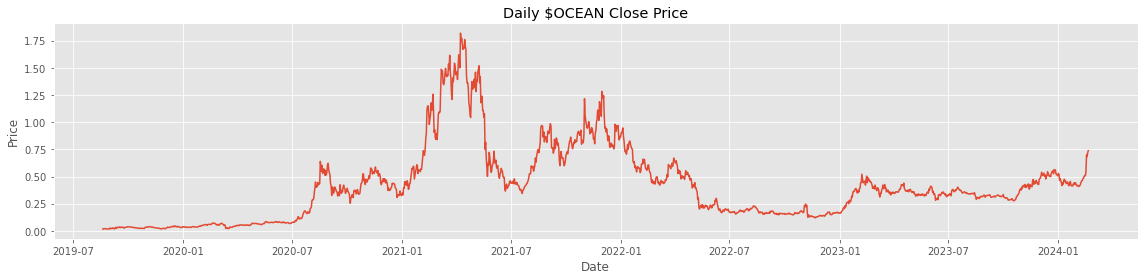

In [145]:
dates = ocean_price['Date'].to_numpy()
closing_price = ocean_price['Close'].to_numpy()

plt.figure(figsize = (16,4))
plt.plot(dates, closing_price)
plt.title('Daily $OCEAN Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [146]:
welcome_bot = 159985870458322944
welcome_channel = 'Ocean Protocol - GET STARTED - 👋︱welcome [727898674637832274]'
#ocean_discord['Is_New_User'] = (ocean_discord['AuthorID'] == welcome_bot) & (ocean_discord['Channel'] == welcome_channel)
#ocean_discord['Cumulative_New_Users'] = ocean_discord.groupby(ocean_discord['Date'].dt.date)['Is_New_User'].count()
#ocean_discord[ocean_discord['Is_New_User']==1]

In [187]:

# Identify the first message sent by each user in the welcome channel
first_messages = ocean_discord[ocean_discord['Channel'] == welcome_channel].groupby('AuthorID')['Date'].min().reset_index()
first_messages.columns = ['AuthorID', 'First_Message_Date']

# Merge the first message information with the original DataFrame
users_activity = pd.merge(ocean_discord, first_messages, on='AuthorID', how='left')

# Create a binary variable to indicate whether a message is the first message sent by each user
users_activity['Is_New_User'] = (users_activity['Channel'] == welcome_channel) & (users_activity['Date'] == users_activity['First_Message_Date'])

# Sum this variable over time to track the cumulative number of new users
#users_activity['Cumulative_New_Users'] = users_activity.groupby(users_activity['Date'].dt.date)['Is_New_User'].()
daily_new_users = users_activity.groupby(users_activity['Date'].dt.date)['Is_New_User'].count().reset_index(name='Daily_New_Users')


In [188]:
daily_new_users

,Date,Daily_New_Users
0,2019-08-20,3
1,2019-08-21,2
2,2019-08-22,16
3,2019-08-23,1
4,2019-08-24,1
...,...,...
1532,2024-02-16,13
1533,2024-02-17,16
1534,2024-02-18,44
1535,2024-02-19,51


In [182]:
# Define rule for active users (e.g., users who sent at least 10 messages per day)
active_users_threshold = 3
users_activity['Active_User'] = users_activity.groupby([users_activity['Date'].dt.date, 'AuthorID'])['Content'].transform('count') >= active_users_threshold

# Calculate daily active users
daily_active_users = users_activity.groupby(users_activity['Date'].dt.date)['Active_User'].sum().reset_index(name='Daily_Active_Users')


In [189]:
message_per_day = ocean_discord.groupby('Date')['message_count'].sum().reset_index(name='Message_Count')

In [163]:
daily_new_users['Date'] = pd.to_datetime(daily_new_users['Date'])
daily_active_users['Date'] = pd.to_datetime(daily_active_users['Date'])
message_per_day['Date'] = pd.to_datetime(message_per_day['Date'])

In [166]:

df_correlations = ocean_price[['Date', 'Close']]

df_correlations = pd.merge(df_correlations, daily_active_users,
                           on = 'Date', how = 'left')
df_correlations = pd.merge(df_correlations, daily_new_users,
                           on = 'Date', how = 'left')
df_correlations = pd.merge(df_correlations, message_per_day,
                           on = 'Date', how = 'left')

df_correlations.fillna(0, inplace=True)

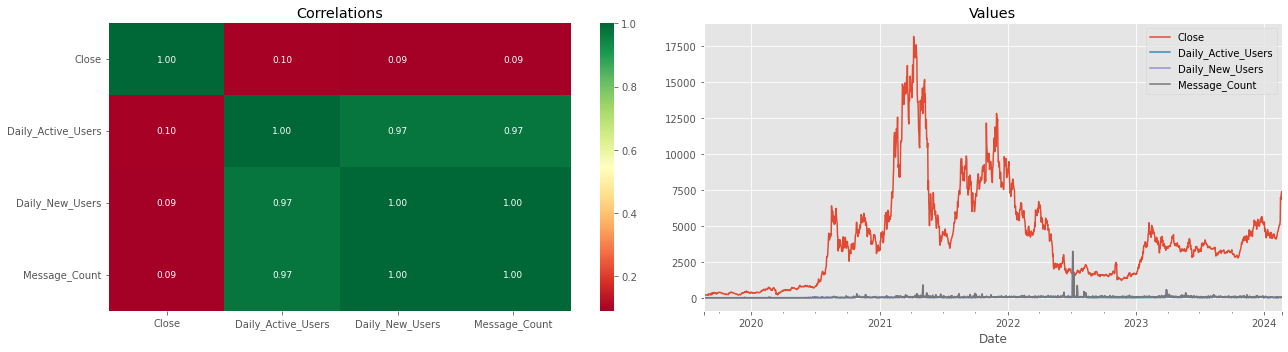

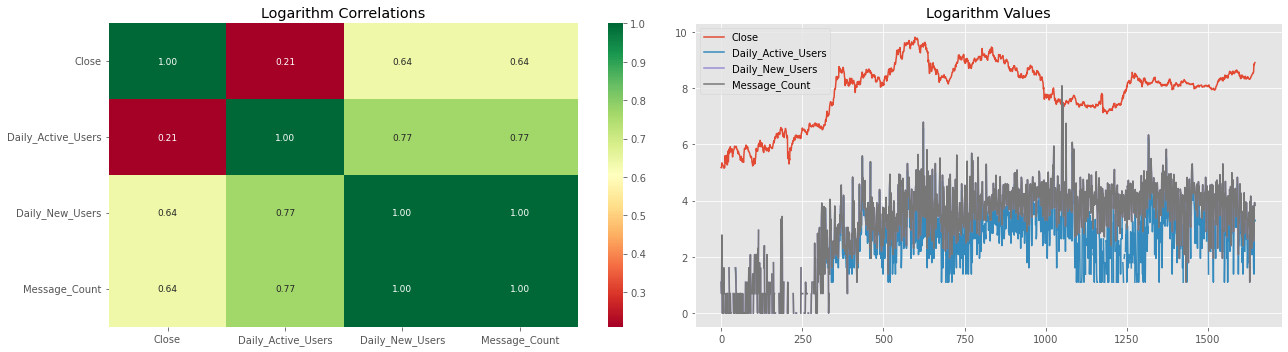

In [180]:
df0 = df_correlations
df0['Close'] = df_correlations.Close * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(df0.drop(columns=['Date']).corr(), ax=axes[0], cmap='RdYlGn', annot=True, fmt='.2f', annot_kws={"size": 9})
axes[0].set_title('Correlations')
df0.plot(ax=axes[1], title='Values', x='Date')
plt.tight_layout()


# Create subplots for logarithmic values
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
# Plot correlation heatmap for logarithmic values
sns.heatmap(np.log(df0.drop(columns=['Date'])).corr(), ax=axes[0], cmap='RdYlGn', annot=True, fmt='.2f', annot_kws={"size": 9})
axes[0].set_title('Logarithm Correlations')
# Plot logarithmic values
np.log(df0.drop(columns=['Date'])).plot(ax=axes[1], title='Logarithm Values')
# Adjust layout
plt.tight_layout()
# Show plots
plt.show()

,Daily_New_Users,Message_Count
Date,,
2019-08-21,2.0,2.0
2019-08-22,16.0,16.0
2019-08-23,1.0,1.0
2019-08-24,1.0,1.0
2019-08-25,1.0,1.0
...,...,...
2024-02-16,13.0,13.0
2024-02-17,16.0,16.0
2024-02-18,44.0,44.0
